In [1]:
import datetime
import math
import sys, os

import numpy as np
import sentencepiece as spm
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from transformers import BertForMaskedLM


/Users/seeusim/University/Y3/Y3S2/CS4248/Project/neural-translation/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
en_model_path = '../../tokenisation/sentencepiece_custom/en.model'
zh_model_path = '../../tokenisation/sentencepiece_custom/zh.model'

en_ds_test_path = '../../tokenisation/data/iwslt2017-en-zh-test.en'
zh_ds_test_path = '../../tokenisation/data/iwslt2017-en-zh-test.zh'

bert_en_path = '../../models/bert-embed/BPE-bert-en'
bert_zh_path = '../../models/bert-embed/BPE-bert-zh'


In [3]:
class SentencePieceBPETokeniser(object):
    PAD_ID = 3  # Defined as sentencepiece custom token

    def __init__(self, lang: str, model_file=None):
        self.model = spm.SentencePieceProcessor(
            model_file=model_file or f"./{lang}.model"
        )
        self.special_ids = (
            self.model.unk_id(),
            SentencePieceBPETokeniser.PAD_ID,  # self.model.pad_id(), # this is -1 and may give errors.
            self.model.bos_id(),
            self.model.eos_id(),
        )

    def __len__(self):
        return len(self.model)

    def encode_batch(self, sents: list[str], max_len=None):
        return [self.encode(sent, max_len) for sent in sents]

    def encode(self, sent: str | list[str], max_len=None):
        if type(sent) == list:
            return self.encode_batch(sent, max_len)
        ids = self.model.encode(sent)
        return ids

    def decode(self, ids: list[int]):
        return self.model.decode(
            list(
                filter(
                    lambda id: id >= 0
                    and id < len(self),
                    ids
                )
            )
        )

    def decode_batch(self, ids: list[list[int]]):
        return [self.decode(id) for id in ids]

    def get_special_ids(self):
        UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = self.special_ids
        return (UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX)

en_tokeniser = SentencePieceBPETokeniser('en', model_file=en_model_path)
zh_tokeniser = SentencePieceBPETokeniser('zh', model_file=zh_model_path)

In [4]:
class BPEBertTokeniser:
    out_keys = [
        "input_ids",
        "token_type_ids",
        "attention_mask",
        "special_tokens_mask",
    ]

    def __init__(self, lang):
        self.lang = lang
        self.pad_token_id = 3

    def _process_id(self, input_ids):
        """
        Called inside the model.
        """
        # src_i: EOS, # trg_i: BOS, #trg_o: EOS
        # input_ids = torch.tensor(input_ids) # 288, padded
        token_type_ids = torch.zeros(input_ids.shape)

        attention_mask = torch.where(input_ids == self.pad_token_id, 0, 1)

        special_tokens_mask = torch.where(input_ids < 4, 1, 0)

        return {
            "input_ids": input_ids,
            "token_type_ids": token_type_ids,
            "attention_mask": attention_mask,
            "special_tokens_mask": special_tokens_mask,
        }

    def encode(self, row):
        if type(row) != torch.Tensor:
            row = torch.tensor(row)
        if len(row.shape) == 1:
            return self.encode_batch(row.unsqueeze(0))
        return self.encode_batch(row)

    def encode_batch(self, rows):
        ids = list(map(lambda row: self._process_id(row), rows))
        return {key: torch.vstack([example[key] for example in ids]) for key in BPEBertTokeniser.out_keys}


    def __call__(self, inputs, **_kwargs):
        return self.encode(inputs)

    def __len__(self):
        return len(self.model)



DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


class BPEBertEmbedder:
    def __init__(self, lang: str, model_file: str):
        # Init the model from the pretrained weights
        self.model = BertForMaskedLM.from_pretrained(
            model_file, output_hidden_states=True
        ).to(DEVICE)
        self.model.eval()

        # Init the BPE tokeniser (padded to length 288, vocab 16384)
        self.tokeniser = BPEBertTokeniser(lang)
        pass

    def embed(self, sent: list[int]):
        tokens = self.tokeniser(
            sent
        )  # input_ids, token_type_mask, attention_mask, special_tokens_mask
        with torch.no_grad():
            input_ids = tokens["input_ids"].to(DEVICE)
            token_type_ids = tokens["token_type_ids"].to(DEVICE)
            attention_mask = tokens["attention_mask"].to(DEVICE)
            # Perform inference
            output = self.model(input_ids, token_type_ids, attention_mask)
            hidden_states = output.hidden_states

            # Permutate and obtain hidden states
        token_embeddings = torch.stack(hidden_states, dim=0)  # 13, batch, 288, 256

        token_embeddings = token_embeddings.permute(1, 2, 0, 3)  # (batch, 288, n_layers, 256)

        # Take last 4 layers
        token_embeddings = token_embeddings[:, :, -4:, :]

        # Take sum of last 4 layers
        token_embeddings = token_embeddings.sum(axis=2)  # (batch, 288, 256)

        token_embeddings.requires_grad_(False)

        # Matrix of embeddings of dim 256, one per word
        return token_embeddings


en_embedder = BPEBertEmbedder('en', bert_en_path)
zh_embedder = BPEBertEmbedder('zh', bert_zh_path)

In [5]:
# Path or parameters for data
RSC_DIR = None

TRAIN_NAME = 'iwslt2017-en-zh-train'

VALID_NAME = 'iwslt2017-en-zh-validation'

# For resuming from checkpoint
CHKPT_NAME = 'ckpt-msk3-20.tar' # The key within the checkpoint directory

SRC_VOCAB_SIZE = 16384
TGT_VOCAB_SIZE = 16384
OUTPUT_VOCAB_SIZE = TGT_VOCAB_SIZE

PAD_IDX = 16384

# Parameters for Transformer & training
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
LEARNING_RATE = 1e-4
BATCH_SIZE = 90
NUM_HEADS = 8
NUM_LAYERS = 6
D_MODEL = 256
D_FF = 1024
D_K = D_MODEL // NUM_HEADS

DROP_OUT_RATE = 0.1
NUM_EPOCHS = 10
BEAM_SIZE = 8

# Resuming training from saved checkpoint
CHECKPOINT_DIR = f'.'

In [6]:
SEQUENCE_LENGTH = 288


def get_data_loader(file_name):
    print(f"Getting source/target {file_name}...")
    with open(f"{RSC_DIR}/{file_name}.en", 'r') as f:
        src_text_list = f.readlines()

    with open(f"{RSC_DIR}/{file_name}.zh", 'r') as f:
        trg_text_list = f.readlines()

    print("Tokenizing & Padding src data...")
    src_list = process_src(src_text_list) # (sample_num, L)
    print(f"The shape of src data: {np.shape(src_list)}")

    print("Tokenizing & Padding trg data...")
    input_trg_list, output_trg_list = process_trg(trg_text_list) # (sample_num, L)
    print(f"The shape of input trg data: {np.shape(input_trg_list)}")
    print(f"The shape of output trg data: {np.shape(output_trg_list)}")

    dataset = CustomDataset(src_list, input_trg_list, output_trg_list)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    return dataloader


def pad_or_truncate(tokenized_text, pad_idx, max_len=SEQUENCE_LENGTH):
    if len(tokenized_text) < max_len:
        left = max_len - len(tokenized_text)
        padding = [pad_idx] * left
        tokenized_text += padding
    else:
        tokenized_text = tokenized_text[:max_len]

    return tokenized_text

MAX_SRC_LEN = 0
MAX_TGT_LEN = 0

MAX_SIZE=300_000

def process_src(text_list):
    """
    Add EOS to end, but only ignore pad
    -> Add BOS, pad start idx and pad end + 1
    """
    _, PAD_IDX, _, EOS_IDX = en_tokeniser.get_special_ids()
    src_input_ids = []
    for text in tqdm(text_list[:MAX_SIZE]):
        ids = en_tokeniser.encode(text.strip())
        src_input_ids.append(pad_or_truncate([PAD_IDX] + ids + [EOS_IDX], PAD_IDX))
    return src_input_ids

def process_trg(text_list):
    """
    Add BOS to start, ignore pad
    -> Add EOS, pad end - 1
    Add EOS to end, ignore pad
    -> Add BOS, pad start idx and pad end + 1
    """
    _, PAD_IDX, BOS_IDX, EOS_IDX = zh_tokeniser.get_special_ids()
    input_tokenized_list = []
    output_tokenized_list = []
    for text in tqdm(text_list[:MAX_SIZE]):
        tokenized = zh_tokeniser.encode(text.strip())
        trg_input = [BOS_IDX] + tokenized
        trg_output = [PAD_IDX] + tokenized + [EOS_IDX]
        input_tokenized_list.append(pad_or_truncate(trg_input, PAD_IDX))
        output_tokenized_list.append(pad_or_truncate(trg_output, PAD_IDX))
    return input_tokenized_list, output_tokenized_list



class CustomDataset(Dataset):
    def __init__(self, src_list, input_trg_list, output_trg_list):
        super().__init__()
        self.src_data = torch.LongTensor(src_list)
        self.input_trg_data = torch.LongTensor(input_trg_list)
        self.output_trg_data = torch.LongTensor(output_trg_list)

        assert np.shape(src_list) == np.shape(input_trg_list), f"The shape of src_list and input_trg_list are different: {np.shape(src_list)} {np.shape(input_trg_list)}"
        assert np.shape(input_trg_list) == np.shape(output_trg_list), f"The shape of input_trg_list and output_trg_list are different: {np.shape(input_trg_list)} {np.shape(output_trg_list)}"

    def __getitem__(self, idx):
        return self.src_data[idx], self.input_trg_data[idx], self.output_trg_data[idx]

    def __len__(self):
        return np.shape(self.src_data)[0]

In [7]:
class EncoderLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_norm_1 = LayerNormalization()
        self.multihead_attention = MultiheadAttention()
        self.drop_out_1 = nn.Dropout(DROP_OUT_RATE)

        self.layer_norm_2 = LayerNormalization()
        self.feed_forward = FeedFowardLayer()
        self.drop_out_2 = nn.Dropout(DROP_OUT_RATE)

    def forward(self, x, e_mask):
        x_1 = self.layer_norm_1(x) # (B, L, d_model)
        x = x + self.drop_out_1(
            self.multihead_attention(x_1, x_1, x_1, mask=e_mask)
        ) # (B, L, d_model)
        x_2 = self.layer_norm_2(x) # (B, L, d_model)
        x = x + self.drop_out_2(self.feed_forward(x_2)) # (B, L, d_model)

        return x # (B, L, d_model)


class DecoderLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_norm_1 = LayerNormalization()
        self.masked_multihead_attention = MultiheadAttention()
        self.drop_out_1 = nn.Dropout(DROP_OUT_RATE)

        self.layer_norm_2 = LayerNormalization()
        self.multihead_attention = MultiheadAttention()
        self.drop_out_2 = nn.Dropout(DROP_OUT_RATE)

        self.layer_norm_3 = LayerNormalization()
        self.feed_forward = FeedFowardLayer()
        self.drop_out_3 = nn.Dropout(DROP_OUT_RATE)

    def forward(self, x, e_output, e_mask,  d_mask):
        x_1 = self.layer_norm_1(x) # (B, L, d_model)
        x = x + self.drop_out_1(
            self.masked_multihead_attention(x_1, x_1, x_1, mask=d_mask)
        ) # (B, L, d_model)
        x_2 = self.layer_norm_2(x) # (B, L, d_model)
        x = x + self.drop_out_2(
            self.multihead_attention(x_2, e_output, e_output, mask=e_mask)
        ) # (B, L, d_model)
        x_3 = self.layer_norm_3(x) # (B, L, d_model)
        x = x + self.drop_out_3(self.feed_forward(x_3)) # (B, L, d_model)

        return x # (B, L, d_model)


class MultiheadAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.inf = 1e9

        # W^Q, W^K, W^V in the paper
        self.w_q = nn.Linear(D_MODEL, D_MODEL)
        self.w_k = nn.Linear(D_MODEL, D_MODEL)
        self.w_v = nn.Linear(D_MODEL, D_MODEL)

        self.dropout = nn.Dropout(DROP_OUT_RATE)
        self.attn_softmax = nn.Softmax(dim=-1)

        # Final output linear transformation
        self.w_0 = nn.Linear(D_MODEL, D_MODEL)

    def forward(self, q, k, v, mask=None):
        input_shape = q.shape

        # Linear calculation +  split into num_heads
        q = self.w_q(q).view(input_shape[0], -1, NUM_HEADS, D_K) # (B, L, num_heads, d_k)
        k = self.w_k(k).view(input_shape[0], -1, NUM_HEADS, D_K) # (B, L, num_heads, d_k)
        v = self.w_v(v).view(input_shape[0], -1, NUM_HEADS, D_K) # (B, L, num_heads, d_k)

        # For convenience, convert all tensors in size (B, num_heads, L, d_k)
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        # Conduct self-attention
        attn_values = self.self_attention(q, k, v, mask=mask) # (B, num_heads, L, d_k)
        concat_output = attn_values.transpose(1, 2)\
            .contiguous().view(input_shape[0], -1, D_MODEL) # (B, L, d_model)

        return self.w_0(concat_output)

    def self_attention(self, q, k, v, mask=None):
        # Calculate attention scores with scaled dot-product attention
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) # (B, num_heads, L, L)
        attn_scores = attn_scores / math.sqrt(D_K)

        # If there is a mask, make masked spots -INF
        if mask is not None:
            mask = mask.unsqueeze(1) # (B, 1, L) => (B, 1, 1, L) or (B, L, L) => (B, 1, L, L)
            attn_scores = attn_scores.masked_fill_(mask == 0, -1 * self.inf)

        # Softmax and multiplying K to calculate attention value
        attn_distribs = self.attn_softmax(attn_scores)

        attn_distribs = self.dropout(attn_distribs)
        attn_values = torch.matmul(attn_distribs, v) # (B, num_heads, L, d_k)

        return attn_values


class FeedFowardLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_1 = nn.Linear(D_MODEL, D_FF, bias=True)
        self.relu = nn.ReLU()
        self.linear_2 = nn.Linear(D_FF, D_MODEL, bias=True)
        self.dropout = nn.Dropout(DROP_OUT_RATE)

    def forward(self, x):
        x = self.relu(self.linear_1(x)) # (B, L, d_ff)
        x = self.dropout(x)
        x = self.linear_2(x) # (B, L, d_model)

        return x


class LayerNormalization(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.layer = nn.LayerNorm([D_MODEL], elementwise_affine=True, eps=self.eps)

    def forward(self, x):
        x = self.layer(x)

        return x


class PositionalEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Make initial positional encoding matrix with 0
        pe_matrix= torch.zeros(SEQUENCE_LENGTH, D_MODEL) # (L, d_model)

        # Calculating position encoding values
        for pos in range(SEQUENCE_LENGTH):
            for i in range(D_MODEL):
                if i % 2 == 0:
                    pe_matrix[pos, i] = math.sin(pos / (10000 ** (2 * i / D_MODEL)))
                elif i % 2 == 1:
                    pe_matrix[pos, i] = math.cos(pos / (10000 ** (2 * i / D_MODEL)))

        pe_matrix = pe_matrix.unsqueeze(0) # (1, L, d_model)
        self.positional_encoding = pe_matrix.to(device=DEVICE).requires_grad_(False)

    def forward(self, x):
        x = x * math.sqrt(D_MODEL) # (B, L, d_model)
        x = x + self.positional_encoding # (B, L, d_model)

        return x

In [8]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, trg_vocab_size):
        super().__init__()
        self.src_vocab_size = src_vocab_size
        self.trg_vocab_size = trg_vocab_size

        self.src_embedding = en_embedder
        self.trg_embedding = zh_embedder
        # self.src_embedding = nn.Embedding(self.src_vocab_size, D_MODEL)
        # self.trg_embedding = nn.Embedding(self.trg_vocab_size, D_MODEL)
        self.positional_encoder = PositionalEncoder()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.output_linear = nn.Linear(D_MODEL, self.trg_vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, src_input, trg_input, e_mask=None, d_mask=None):
        src_input = self.src_embedding.embed(src_input)
        trg_input = self.trg_embedding.embed(trg_input)

        src_input = self.positional_encoder(src_input) # (B, L, d_model) => (B, L, d_model)
        trg_input = self.positional_encoder(trg_input) # (B, L, d_model) => (B, L, d_model)

        e_output = self.encoder(src_input, e_mask) # (B, L, d_model)
        d_output = self.decoder(trg_input, e_output, e_mask, d_mask) # (B, L, d_model)

        output = self.softmax(self.output_linear(d_output)) # (B, L, d_model) => # (B, L, trg_vocab_size)

        return output


class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([EncoderLayer() for i in range(NUM_LAYERS)])
        self.layer_norm = LayerNormalization()

    def forward(self, x, e_mask):
        for i in range(NUM_LAYERS):
            x = self.layers[i](x, e_mask)

        return self.layer_norm(x)


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([DecoderLayer() for i in range(NUM_LAYERS)])
        self.layer_norm = LayerNormalization()

    def forward(self, x, e_output, e_mask, d_mask):
        for i in range(NUM_LAYERS):
            x = self.layers[i](x, e_output, e_mask, d_mask)

        return self.layer_norm(x)

In [9]:
import heapq


class BeamNode():
    def __init__(self, cur_idx, prob, decoded):
        self.cur_idx = cur_idx
        self.prob = prob
        self.decoded = decoded
        self.is_finished = False
        
    def __gt__(self, other):
        return self.prob > other.prob
    
    def __ge__(self, other):
        return self.prob >= other.prob
    
    def __lt__(self, other):
        return self.prob < other.prob
    
    def __le__(self, other):
        return self.prob <= other.prob
    
    def __eq__(self, other):
        return self.prob == other.prob
    
    def __ne__(self, other):
        return self.prob != other.prob
    
    def print_spec(self):
        print(f"ID: {self} || cur_idx: {self.cur_idx} || prob: {self.prob} || decoded: {self.decoded}")
    

class PriorityQueue():
    def __init__(self):
        self.queue = []
        
    def put(self, obj):
        heapq.heappush(self.queue, (obj.prob, obj))
        
    def get(self):
        return heapq.heappop(self.queue)[1]
    
    def qsize(self):
        return len(self.queue)
    
    def print_scores(self):
        scores = [t[0] for t in self.queue]
        print(scores)
        
    def print_objs(self):
        objs = [t[1] for t in self.queue]
        print(objs)
    

In [10]:
import copy

BEAM_SIZE = 8

class Manager():
    def __init__(self, is_train=True, ckpt_name=None):

        # Load Transformer model & Adam optimizer
        print("Loading Transformer model & Adam optimizer...")
        self.model = Transformer(src_vocab_size=SRC_VOCAB_SIZE, trg_vocab_size=TGT_VOCAB_SIZE).to(DEVICE)
        self.optim = torch.optim.Adam(self.model.parameters(), lr=LEARNING_RATE)
        self.best_loss = sys.float_info.max

        if ckpt_name is not None:
            assert os.path.exists(f"{CHECKPOINT_DIR}/{ckpt_name}"), f"There is no checkpoint named {ckpt_name}."

            print("Loading checkpoint...")
            checkpoint = torch.load(f"{CHECKPOINT_DIR}/{ckpt_name}", map_location=DEVICE)
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.optim.load_state_dict(checkpoint['optim_state_dict'])
            self.best_loss = checkpoint['loss']
        else:
            print("Initializing the model...")
            for p in self.model.parameters():
                if p.dim() > 1:
                    nn.init.xavier_uniform_(p)

        if is_train:
            # Load loss function
            print("Loading loss function...")
            self.criterion = nn.NLLLoss()

            # Load dataloaders
            print("Loading dataloaders...")
            self.train_loader = get_data_loader(TRAIN_NAME)
            self.valid_loader = get_data_loader(VALID_NAME)

        print("Setting finished.")

    def train(self):
        print("Training starts.")
        stag_ct = 0
        for epoch in range(1, NUM_EPOCHS+1):
            self.model.train()

            train_losses = []
            start_time = datetime.datetime.now()

            for i, batch in tqdm(enumerate(self.train_loader)):
                src_input, trg_input, trg_output = batch
                src_input, trg_input, trg_output = src_input.to(DEVICE), trg_input.to(DEVICE), trg_output.to(DEVICE)

                e_mask, d_mask = self.make_mask(src_input, trg_input)

                output = self.model(src_input, trg_input, e_mask, d_mask) # (B, L, vocab_size)

                trg_output_shape = trg_output.shape
                self.optim.zero_grad()
                loss = self.criterion(
                    output.view(-1, OUTPUT_VOCAB_SIZE),
                    trg_output.view(trg_output_shape[0] * trg_output_shape[1])
                )

                loss.backward()
                self.optim.step()

                train_losses.append(loss.item())

                del src_input, trg_input, trg_output, e_mask, d_mask, output
                torch.cuda.empty_cache()

            end_time = datetime.datetime.now()
            training_time = end_time - start_time
            seconds = training_time.seconds
            hours = seconds // 3600
            minutes = (seconds % 3600) // 60
            seconds = seconds % 60

            mean_train_loss = np.mean(train_losses)
            print(f"#################### Epoch: {epoch} ####################")
            print(f"Train loss: {mean_train_loss} || One epoch training time: {hours}hrs {minutes}mins {seconds}secs")

            valid_loss, valid_time = self.validation()

            if valid_loss < self.best_loss:
                if not os.path.exists(CHECKPOINT_DIR):
                    os.mkdir(CHECKPOINT_DIR)

                self.best_loss = valid_loss
                state_dict = {
                    'model_state_dict': self.model.state_dict(),
                    'optim_state_dict': self.optim.state_dict(),
                    'loss': self.best_loss
                }
                torch.save(state_dict, f"{CHECKPOINT_DIR}/ckpt-{epoch}.tar")
                print(f"***** Current best checkpoint is saved. *****")
                stag_ct = 0
            else:
                stag_ct += 1


            print(f"Best valid loss: {self.best_loss}")
            print(f"Valid loss: {valid_loss} || One epoch training time: {valid_time}")

            if stag_ct >= 3:
                print("Has not improved for 3 epochs. Stopping training.")
                break

        print(f"Training finished!")

    def validation(self):
        print("Validation processing...")
        self.model.eval()

        valid_losses = []
        start_time = datetime.datetime.now()

        with torch.no_grad():
            for i, batch in tqdm(enumerate(self.valid_loader)):
                src_input, trg_input, trg_output = batch
                src_input, trg_input, trg_output = src_input.to(DEVICE), trg_input.to(DEVICE), trg_output.to(DEVICE)

                e_mask, d_mask = self.make_mask(src_input, trg_input)

                output = self.model(src_input, trg_input, e_mask, d_mask) # (B, L, vocab_size)

                trg_output_shape = trg_output.shape
                loss = self.criterion(
                    output.view(-1, OUTPUT_VOCAB_SIZE),
                    trg_output.view(trg_output_shape[0] * trg_output_shape[1])
                )

                valid_losses.append(loss.item())

                del src_input, trg_input, trg_output, e_mask, d_mask, output
                torch.cuda.empty_cache()

        end_time = datetime.datetime.now()
        validation_time = end_time - start_time
        seconds = validation_time.seconds
        hours = seconds // 3600
        minutes = (seconds % 3600) // 60
        seconds = seconds % 60

        mean_valid_loss = np.mean(valid_losses)

        return mean_valid_loss, f"{hours}hrs {minutes}mins {seconds}secs"

    def make_mask(self, src_input, trg_input):
        # src_input: (B, L, d_model)
        e_mask = (src_input != en_tokeniser.PAD_ID).unsqueeze(1)  # (B, 1, L)
        d_mask = (trg_input != zh_tokeniser.PAD_ID).unsqueeze(1)  # (B, 1, L)

        nopeak_mask = torch.ones([1, SEQUENCE_LENGTH, SEQUENCE_LENGTH], dtype=torch.bool)  # (1, L, L)
        nopeak_mask = torch.tril(nopeak_mask).to(DEVICE)  # (1, L, L) to triangular shape
        d_mask = d_mask & nopeak_mask  # (B, L, L) padding false

        return e_mask, d_mask

    def beam_search(self, e_output, e_mask):
        _, TGT_PAD_IDX, TGT_BOS_IDX, TGT_EOS_IDX = zh_tokeniser.get_special_ids()
        cur_queue = PriorityQueue()
        
        for _ in range(BEAM_SIZE):
            cur_queue.put(BeamNode(TGT_BOS_IDX, -0.0, [TGT_BOS_IDX]))
        
        finished_count = 0

        SEQUENCE_LENGTH = 288
        
        for pos in range(SEQUENCE_LENGTH):
            new_queue = PriorityQueue()
            for k in range(BEAM_SIZE):
                node = cur_queue.get()
                if node.is_finished:
                    new_queue.put(node)
                else:
                    trg_input = torch.LongTensor(node.decoded + [TGT_PAD_IDX] * (SEQUENCE_LENGTH - len(node.decoded))).to(DEVICE) # (L)
                    d_mask = (trg_input.unsqueeze(0) != TGT_PAD_IDX).unsqueeze(1).to(DEVICE) # (1, 1, L)
                    nopeak_mask = torch.ones([1, SEQUENCE_LENGTH, SEQUENCE_LENGTH], dtype=torch.bool).to(DEVICE)
                    nopeak_mask = torch.tril(nopeak_mask) # (1, L, L) to triangular shape
                    d_mask = d_mask & nopeak_mask # (1, L, L) padding false
                    
                    trg_embedded = self.model.trg_embedding.embed(trg_input.unsqueeze(0))
                    trg_positional_encoded = self.model.positional_encoder(trg_embedded)
                    decoder_output = self.model.decoder(
                        trg_positional_encoded,
                        e_output,
                        e_mask,
                        d_mask
                    ) # (1, L, d_model)

                    output = self.model.softmax(
                        self.model.output_linear(decoder_output)
                    ) # (1, L, trg_vocab_size)
                    
                    output = torch.topk(output[0][pos], dim=-1, k=BEAM_SIZE)
                    last_word_ids = output.indices.tolist() # (k)
                    last_word_prob = output.values.tolist() # (k)
                    
                    for i, idx in enumerate(last_word_ids):
                        new_node = BeamNode(idx, -(-node.prob + last_word_prob[i]), node.decoded + [idx])
                        if idx == TGT_EOS_IDX:
                            new_node.prob = new_node.prob / float(len(new_node.decoded))
                            new_node.is_finished = True
                            finished_count += 1
                        new_queue.put(new_node)
            
            cur_queue = copy.deepcopy(new_queue)
            
            if finished_count == BEAM_SIZE:
                break
        
        decoded_output = cur_queue.get().decoded
        
        if decoded_output[-1] == TGT_EOS_IDX:
            decoded_output = decoded_output[1:-1]
        else:
            decoded_output = decoded_output[1:]
            
        return zh_tokeniser.decode(decoded_output)

    def translate(self, text: str, verbose=False):
        _, SRC_PAD, _, SRC_EOS = en_tokeniser.get_special_ids()
        tokenized = en_tokeniser.encode(text)
        src_data = torch.LongTensor(
            pad_or_truncate([SRC_PAD] + tokenized + [SRC_EOS], SRC_PAD)
        ).unsqueeze(0).to(DEVICE) # (1, L)
        e_mask = (src_data != SRC_PAD).unsqueeze(1).to(DEVICE) # (1, 1, L)

        start_time = datetime.datetime.now()

        if verbose:
            print("Encoding input sentence...")
        src_data = self.model.src_embedding.embed(src_data)
        src_data = self.model.positional_encoder(src_data)
        e_output = self.model.encoder(src_data, e_mask) # (1, L, d_model)

        
        result = self.beam_search(e_output, e_mask)

        end_time = datetime.datetime.now()

        total_inference_time = end_time - start_time
        seconds = total_inference_time.seconds
        minutes = seconds // 60
        seconds = seconds % 60

        if verbose:
            print(f"Input: {text}")
            print(f"Result: {result}")
            print(f"Inference finished! || Total inference time: {minutes}mins {seconds}secs")

        return result

In [11]:
import logging

torch._logging.set_logs(dynamo = logging.INFO)

In [12]:
m = Manager(is_train=False, ckpt_name=CHKPT_NAME)

Loading Transformer model & Adam optimizer...
Loading checkpoint...
Setting finished.


In [13]:
with open(en_ds_test_path, 'r') as f:
    sent = f.readline()
    # sent = f.readline()
    # sent = f.readline()

sent

'Several years ago here at TED, Peter Skillman  introduced a design challenge  called the marshmallow challenge.\n'

In [14]:
m.translate(sent.strip())


'这是TED演讲的TED演讲, 叫做“ ⁇ ”的项目。'

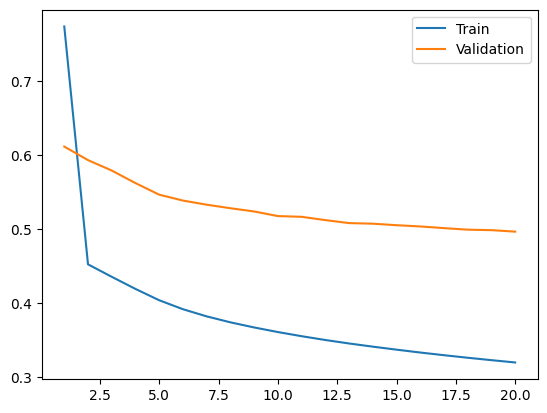